## Aerobic/anaerobic phenotype: data analysis, processing, and visualization

#### 1. Read the train and test datasets and analyse the number of aerobs/anaerobs
First, we read and explore the datasets that were used for classifier trainings in the manuscript: the original (without noise), training, and test (with noise) datasets. 

In [1]:
import sys
import os

# Add the parent directory to sys.path (to import util function)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from utils.utils import read_xy_data, find_accuracies, plot_results

data_filename_train = "../data_aerob/all_gene_annotations.added_incompleteness_and_contamination.training.tsv"
data_filename_test = "../data_aerob/all_gene_annotations.added_incompleteness_and_contamination.testing.tsv"
data_filename_orig = "../data_aerob/all_gene_annotations.tsv"
y_filename = "../data_aerob/bacdive_scrape_20230315.json.parsed.anaerobe_vs_aerobe.with_cyanos.csv"

In [2]:

# Train dataset
d3_train, X_train, y_train = read_xy_data(data_filename_train, y_filename)
num_aerobs_train = y_train['oxytolerance'].sum()
num_anaerobs_train = len(y_train['oxytolerance']) - num_aerobs_train

print(f"Total number of genomes for training = {num_aerobs_train+num_anaerobs_train}")
print(f"Percentage of aerobs in train dataset {round(num_aerobs_train/(num_aerobs_train + num_anaerobs_train), 2)}")

Counts of each class in training/test data: shape: (2, 2)
┌──────────────┬───────┐
│ oxytolerance ┆ len   │
│ ---          ┆ ---   │
│ str          ┆ u32   │
╞══════════════╪═══════╡
│ aerobe       ┆ 58356 │
│ anaerobe     ┆ 29808 │
└──────────────┴───────┘
Total number of genomes for training = 88164
Percentage of aerobs in train dataset 0.66


In [3]:
# Test dataset
d3_test, X_test, y_test = read_xy_data(data_filename_test, y_filename)
num_aerobs_test = y_test['oxytolerance'].sum()
num_anaerobs_test = len(y_test['oxytolerance']) - num_aerobs_test

print(f"Total number of genomes for testing = {num_aerobs_test+num_anaerobs_test}")
print(f"Percentage of aerobs in test dataset {round(num_aerobs_test/(num_aerobs_test + num_anaerobs_test), 2)}")

Counts of each class in training/test data: shape: (2, 2)
┌──────────────┬───────┐
│ oxytolerance ┆ len   │
│ ---          ┆ ---   │
│ str          ┆ u32   │
╞══════════════╪═══════╡
│ anaerobe     ┆ 8172  │
│ aerobe       ┆ 17460 │
└──────────────┴───────┘
Total number of genomes for testing = 25632
Percentage of aerobs in test dataset 0.68


In [ ]:
# Original dataset
d3_orig, X_orig, y_orig = read_xy_data(data_filename_orig, y_filename)
num_aerobs_orig = y_test['oxytolerance'].sum()
num_anaerobs_orig = len(y_test['oxytolerance']) - num_aerobs_orig

print(f"Total number of genomes for testing = {num_aerobs_orig+num_anaerobs_orig}")
print(f"Percentage of aerobs in test dataset {round(num_aerobs_orig/(num_aerobs_orig + num_anaerobs_orig), 2)}")

#### 2. Data sub-sampling (can be ignored)
Due to the data imbalance (both the training and test datasets have more aerobs than anaerobs), we perform data sub-sampling, i.e. we randomly subsample aerobs, so their totatl number = the total number of anaerobs. 

In [ ]:
import random 
from utils.utils import table_row_subsampling

random.seed(42)

In [ ]:
X_subsampled_train, y_subsampled_train = table_row_subsampling(d3_train)

In [ ]:
X_subsampled_test, y_subsampled_test = table_row_subsampling(d3_test)

In [ ]:
X_subsampled_orig, y_subsampled_orig = table_row_subsampling(d3_orig) 

The sub-sampled datasets are saved to the corresponding files, so they can be used for model training, if needed.

In [12]:
import pandas as pd

df_train = pd.DataFrame(X_subsampled_train)
filename = '../data_aerob/all_gene_annotations.added_incompleteness_and_contamination.subsampled.training.tsv'
df_train.to_csv(filename, sep="\t", index=False)

df_test = pd.DataFrame(X_subsampled_test)
filename = '../data_aerob/all_gene_annotations.added_incompleteness_and_contamination.subsampled.testing.tsv'
df_test.to_csv(filename, sep="\t", index=False)

df_orig = pd.DataFrame(X_subsampled_orig)
filename = '../data_aerob/all_gene_annotations.subsampled.tsv'
df_orig.to_csv(filename, sep="\t", index=False)

#### 3. PCA for data visualization


Use PCA to reduce the data dimensionality and visualize it.

Data after PCA reduction: (2110, 20)
Explained variance ratio: [0.11218065 0.06286769 0.05417358 0.04568379 0.03426689 0.02679777
 0.0213585  0.01846339 0.01652377 0.01562154 0.01112686 0.01092909
 0.00937023 0.00862675 0.00797257 0.00706873 0.00640158 0.00626506
 0.00615129 0.00563174]
Total explained variance: 0.4874814766059977


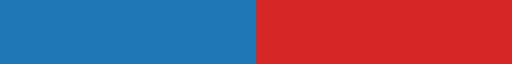

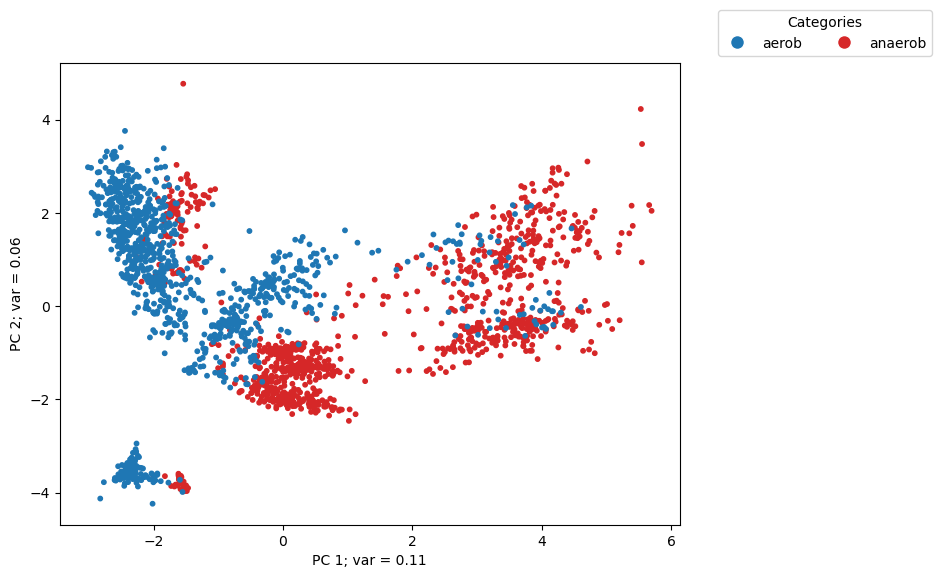

In [13]:
from utils.utils import pca_run_and_plot
from matplotlib.colors import ListedColormap


# Create datasets with values only
X_val = X_subsampled_orig.drop(['accession','phylum','class','order','family','genus'], axis = 1)#'false_negative_rate',	'false_positive_rate'], axis = 1).values#X_subsampled_train_val#.values
y_val = y_subsampled_orig.values

n_compon = 20
colors = ListedColormap(["tab:blue", "tab:red"])
category_names = ["aerob" if yi == 0 else "anaerob" for yi in y_val]

pca_run_and_plot(X_val, y_val, category_names, n_compon, colors)



PCA doesn't explain the complexity of the data well: the first two components explain ~20% of the variance in total only. Moreover, the separation between aerobs and anaerobs is not clean. This indicates that the data has a more complex non-linear structure, or the noise is dominating. Also, it might indicate that the number of features in the 2D linear PCA space isn't enough, i.e. the dependence between the data and the oxyadaptation feature might still be relatively simple and linear but in a higher-dimensional space (since the LogisticRegression performs well on this data). 

We can also color the samples in the PCA space with respect to their belonging to a class/family/genus etc. This is a useful thing to do to make sure that we have a category separation that has a different "resolution" comapring to aerobs/anaerobs.

In [16]:
df_orig['phylum']

0       p__Actinobacteriota
1         p__Proteobacteria
2       p__Actinobacteriota
3         p__Proteobacteria
4        p__Acidobacteriota
               ...         
2105        p__Firmicutes_A
2106        p__Firmicutes_A
2107        p__Firmicutes_C
2108        p__Firmicutes_A
2109        p__Firmicutes_C
Name: phylum, Length: 2110, dtype: object

98


(array([221., 236., 311.,   5.,   9.,   1.,  67., 151.,   7., 190.,  27.,
         29.,   5.,   1.,   3.,   6.,   4.,  11.,  20.,   3.,   5.,   4.,
          2.,  11.,   1.,   1.,   1.,  18.,  18.,  18., 272.,  23.,  29.,
          1.,  14.,   6.,   1.,  11.,  20.,  29.,   7.,   1.,   8.,   3.,
          4.,  13.,   2.,  18.,   6.,  12.,   3.,   2.,   2.,   2.,   3.,
         12.,  34.,  18.,  52.,   2.,   8.,   5.,   2.,   3.,   8.,   6.,
          1.,   3.,   7.,   5.,   2.,   1.,   8.,  19.,   2.,   1.,   1.,
          1.,   1.,   1.,   1.,   1.,   6.,   1.,   1.,   2.,   2.,   1.,
          1.,   2.,   2.,   1.,   1.,   1.,   1.,   1.,   2.,   2.]),
 array([ 0.        ,  0.98979592,  1.97959184,  2.96938776,  3.95918367,
         4.94897959,  5.93877551,  6.92857143,  7.91836735,  8.90816327,
         9.89795918, 10.8877551 , 11.87755102, 12.86734694, 13.85714286,
        14.84693878, 15.83673469, 16.82653061, 17.81632653, 18.80612245,
        19.79591837, 20.78571429, 21.7755102 ,

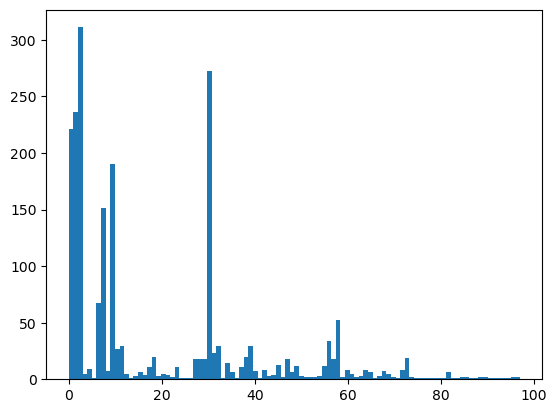

In [17]:
import numpy as np
import matplotlib.pyplot as plt
level = 'class' # <-- choose the level for the visualization here
category_id_train = pd.factorize(df_train[level])[0]
category_id_test = pd.factorize(df_test[level])[0]
category_id_orig = pd.factorize(df_orig[level])[0]

num_categ = len(np.unique(category_id_orig))
print(num_categ)
plt.hist(category_id_orig, bins = num_categ)

Data after PCA reduction: (2110, 20)
Explained variance ratio: [0.11218065 0.06286769 0.05417358 0.04568379 0.03426689 0.02679777
 0.0213585  0.01846339 0.01652377 0.01562154 0.01112686 0.01092909
 0.00937024 0.00862676 0.00797272 0.00706873 0.00640139 0.00626518
 0.00615169 0.00564102]
Total explained variance: 0.48749126487153666


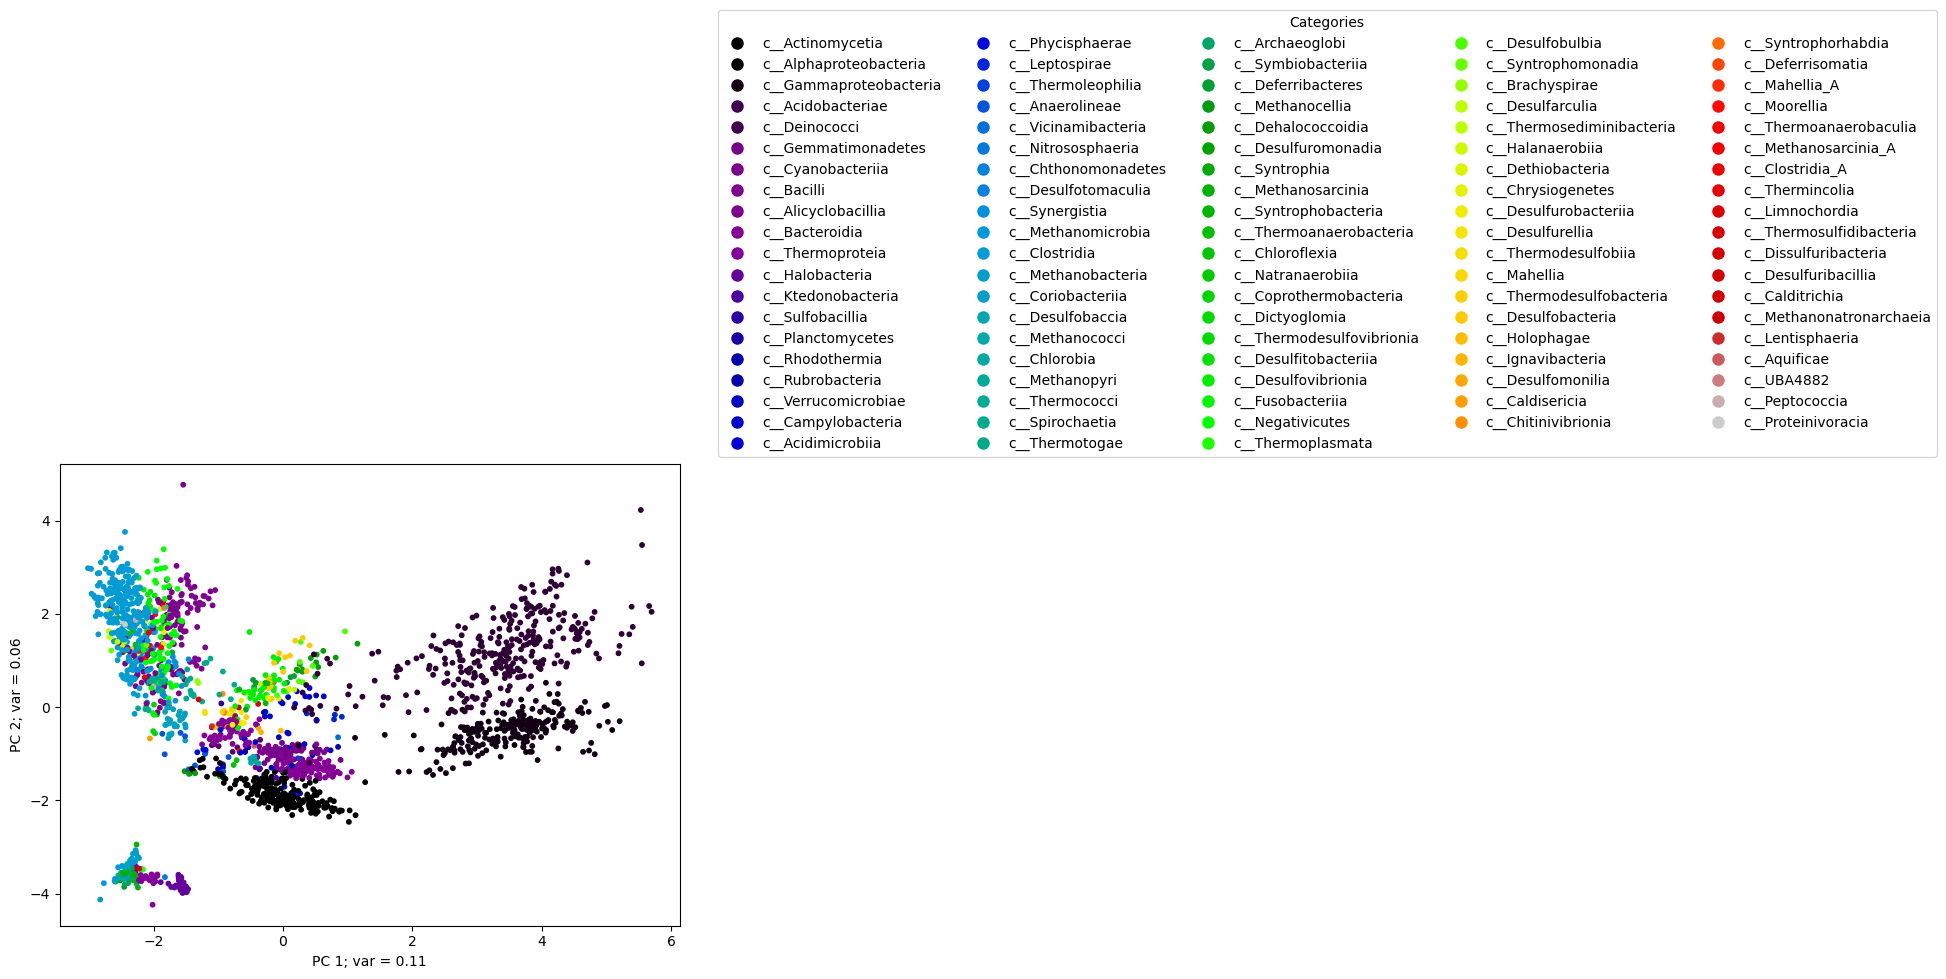

In [18]:
n_compon = 20
category_names = df_orig[level].tolist()

listed_cmap = pca_run_and_plot(X_val, category_id_orig, category_names, n_compon, 'nipy_spectral') 


#### 4. tSNE for data visualization


Next, we try tSNE which is a non-linear method for data dimensionality reduction and visualization. 

In [19]:
# Prepare the dataset
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()

# Fit and transform the data
X_val = scaler.fit_transform(X_val)

In [20]:
from sklearn.manifold import TSNE

# Initialize and apply t-SNE
tsne = TSNE(n_components=2, perplexity=50, learning_rate=100, max_iter=3000, init='pca') 
X_tsne = tsne.fit_transform(X_val) 

print(X_tsne.shape)

(2110, 2)


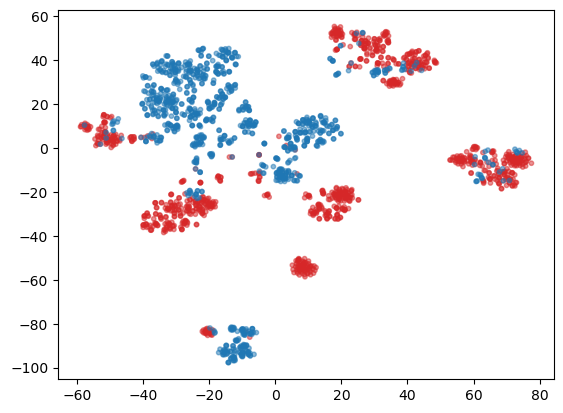

In [21]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
colors = ListedColormap(["tab:blue", "tab:red"])

# Visualize the t-SNE output
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_val, alpha=0.5, s = 10, cmap=colors)

At the same time, the tSNE space provides more insights about the local structure of the data. Here, we can see multiple sub-clusters with aerobs and anaerobs. 

Similarly, we color the samples in the tSNE space with respect to their belonging to a class.

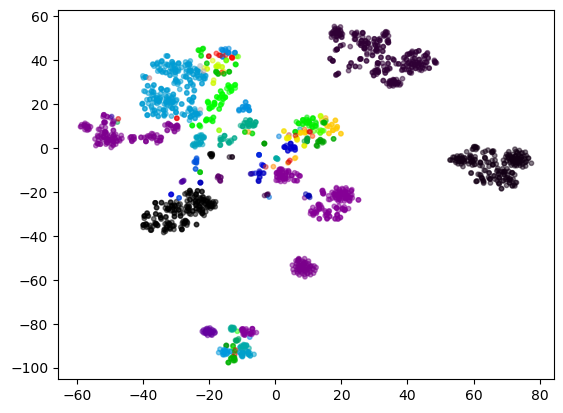

In [22]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=category_id_orig, alpha=0.5, s = 10, cmap=listed_cmap)

Based on the visualization, the tSNE sub-clusters might correspond to the sample classes (or some other more fine hierarcical organization).

#### 5. Plot training accuracies for different values of gene adding and gene removal rates (might need to re-start the kernel here)

In [ ]:
import os

original_dir = os.getcwd()
print(original_dir)
os.chdir(original_dir)


result_directory = "../results/SetTransformer/aerob/"

# Specify the number of inducing points for plotting the results 
num_ind_points = 2
fp_to_plot = [0, 0.1, 0.2, 0.5]
tables_average_folds = find_accuracies(num_ind_points, result_directory)
plot_results('matching_probability', num_ind_points, fp_to_plot, tables_average_folds)